## Label Maker with Dask and Planetary Computer

This notebook shows how to run [label-maker](https://github.com/developmentseed/label-maker) with [dask](https://dask.org/) using [Planetary Computer](https://planetarycomputer.microsoft.com/). Label Maker is a library for creating machine-learning ready data by pairing satellite images with [OpenStreetMap](https://www.openstreetmap.org/) (OSM) vector data. It fetches data from both sources and then divides them into smaller image chips based on [slippy map conventions](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames).

### Environment Setup
We'll add our dependencies and use dask locally for ease of setup. For running a remote cluster, see the setup in [the dask example](../quickstarts/scale-with-dask.ipynb)

In [1]:
!pip install --upgrade -q git+https://github.com/developmentseed/label-maker-dask.git
import planetary_computer as pc
import pystac
from label_maker_dask import LabelMakerJob
from dask.distributed import Client

In [ ]:
client = Client()

### Finding Source Imagery
You can use any tiled imagery (WMS/TMS) endpoint or Cloud-Optimized GeoTIFF file as the imagery input to `label-maker`. In this case, we follow the [Sentinel 2 L2A Example](..datasets/sentinel-2-l2a/sentinel-2-l2a-example.ipynb) to get an asset URL and sign it with our Planetary Computer SAS token.

In [3]:
item = pystac.read_file(
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2A_MSIL2A_20190724T112121_R037_T29SMC_20201005T185645"  # noqa: E501
)
asset_href = item.assets["visual"].href
signed_href = pc.sign(asset_href)

### Label-Maker-Dask
Now that we have everything setup, we can supply the parameters to define our `label-maker` job:
- `zoom`: *int*. The [zoom level](https://wiki.openstreetmap.org/wiki/Zoom_levels) used to create images. This functions as a rough proxy for resolution. Value should be given as an int on the interval `[0, 19]`
- `bounds`: *List[float]*. The bounding box to create images from. This should be given in the form: `[xmin, ymin, xmax, ymax]` as longitude and latitude values between `[-180, 180]` and `[-90, 90]`, respectively. Values should use the WGS84 datum, with longitude and latitude units in decimal degrees.
- `classes`: *List*. The training classes. Each class is defined as dict object with two required keys:
  - `name`: *str*. The class name.
  - `filter`: *List[str]*. A [Mapbox GL Filter](https://www.mapbox.com/mapbox-gl-js/style-spec#other-filter) to define any vector features matching this class. Filters are applied with the standalone [featureFilter](https://github.com/mapbox/mapbox-gl-js/tree/main/src/style-spec/feature_filter#api) from Mapbox GL JS.
- `imagery`: *str*. Details at https://developmentseed.org/label-maker/parameters.html#parameters
- `ml_type`: *str*. One of 'classification', 'object-detection', or 'segmentation'. More details at https://developmentseed.org/label-maker/parameters.html#parameters
- `label_source`: *str*. A template string for a tile server providing OpenStreetMap QA tiles. Planetary Computer hosts a tile server supporting this format at https://qa-tiles-server-dev.ds.io/services/z17/tiles/{z}/{x}/{y}.pbf

Once the job is defined, we can use the `build_job` and `execute_job` methods to fetch our labels and imagery.

In [4]:
lmj = LabelMakerJob(
    zoom=15,
    bounds=[-9.232635498046, 38.70265930723, -9.0966796875, 38.78138720209],
    classes=[
        {"name": "Roads", "filter": ["has", "highway"]},
        {"name": "Buildings", "filter": ["has", "building"]},
    ],
    imagery=signed_href,
    ml_type="segmentation",
    label_source="https://qa-tiles-server-dev.ds.io/services/z17/tiles/{z}/{x}/{y}.pbf",
)

Sample graph


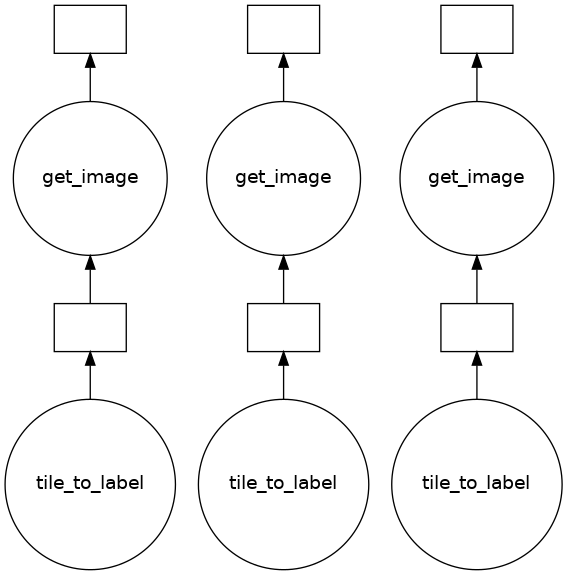

In [5]:
lmj.build_job()

In [6]:
# a quick check on the number of image chips/tiles
lmj.n_tiles()

143

In [ ]:
lmj.execute_job()


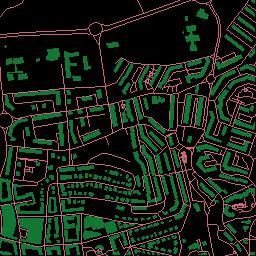
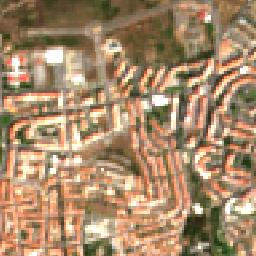

In [8]:
lmj.results[2]

### What Next?
The `results` property has viewing options for the various machine learning types, but we're really interested in passing the images and labels to a machine learning framework. We can setup the learning process similar to this:

```python
model = ...
X = np.stack([result.label for result in lmj.results])
y = np.stack([result.image for result in lmj.results])
model.fit(X, y)
```

### Resources
Check out these other notebooks for help running your own cluster or finding your own images:
- [Scale with Dask](../quickstarts/scale-with-dask.ipynb)
- [Reading Data from the STAC API](../quickstarts/reading-stac.ipynb)
